In [128]:
import pandas as pd
from nltk.corpus import stopwords
import numpy as np
import string 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TweetTokenizer, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence, TaggedDocument
import multiprocessing
from sklearn import utils

In [122]:
#import annotated data
df = pd.read_csv('annotated_tweets.csv', engine='python')
df = df.drop('Unnamed: 0', axis=1)
df.columns

Index(['created_at', 'id', 'user_id', 'user_location', 'status', 'text'], dtype='object')

# Natural Language Processing

## TF-IDF Vectorization

In [13]:
def tokenize(tweet):
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
    return tknzr.tokenize(tweet)

data = df['text']
labels = df['status']
train_data, test_data, y_train, y_test = train_test_split(data, labels)

tfidfvec = TfidfVectorizer(stop_words='english', tokenizer=tokenize)

x_train = tfidfvec.fit_transform(train_data)
x_test = tfidfvec.transform(test_data)

### Feature Extraction

In [20]:
dftrain = pd.DataFrame(x_train.toarray())
dftrain.columns = tfidfvec.get_feature_names()

In [15]:
len(tfidfvec.get_feature_names())

5741

In [40]:
def top_feature_extraction(vectorizer, num_features):
    unrelated_doc_matrix = vectorizer.transform(df[df.status == 0].text)
    related_doc_matrix = vectorizer.transform(df[df.status == 1].text)
    unrelated_tf = np.sum(neg_doc_matrix,axis=0)
    related_tf = np.sum(pos_doc_matrix,axis=0)
    unrelated = np.squeeze(np.asarray(neg_tf))
    related = np.squeeze(np.asarray(pos_tf))
    term_freq_df = pd.DataFrame([neg,pos],columns=tfidfvec.get_feature_names()).transpose()
    term_freq_df.columns = ['unrelated', 'related']
    term_freq_df['total'] = term_freq_df['unrelated'] + term_freq_df['related']
    display(term_freq_df.sort_values(by='total', ascending=False).iloc[:num_features])
    return term_freq_df

In [41]:
term_freq_df = top_feature_extraction(tfidfvec, 10)

,unrelated,related,total
flu,153.618892,195.951336,349.570228
getting,99.708204,182.453405,282.161610
swine,118.454579,129.042282,247.496861
shot,87.543514,77.230363,164.773877
bird,78.436628,59.689096,138.125724
rt,55.048275,42.959432,98.007707
vaccine,61.652818,26.281509,87.934327
sick,14.030018,70.201950,84.231968
worried,32.168039,48.125559,80.293598
just,18.194242,53.248472,71.442715


### Unrelated vs. Related Frequencies for Token

Text(0.5,1,'Unrelated Frequency vs Related Frequency')

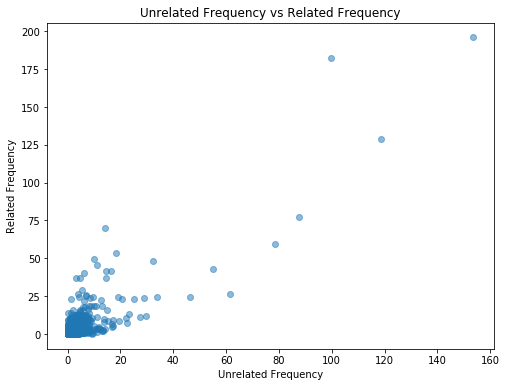

In [25]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="unrelated", y="related",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Related Frequency')
plt.xlabel('Unrelated Frequency')
plt.title('Unrelated Frequency vs Related Frequency')
#no evident relationship between unrelated and related frequency

### Top 10 Tokens in Related Tweets

Text(0.5,1,'Top 20 tokens in flu-related tweets')

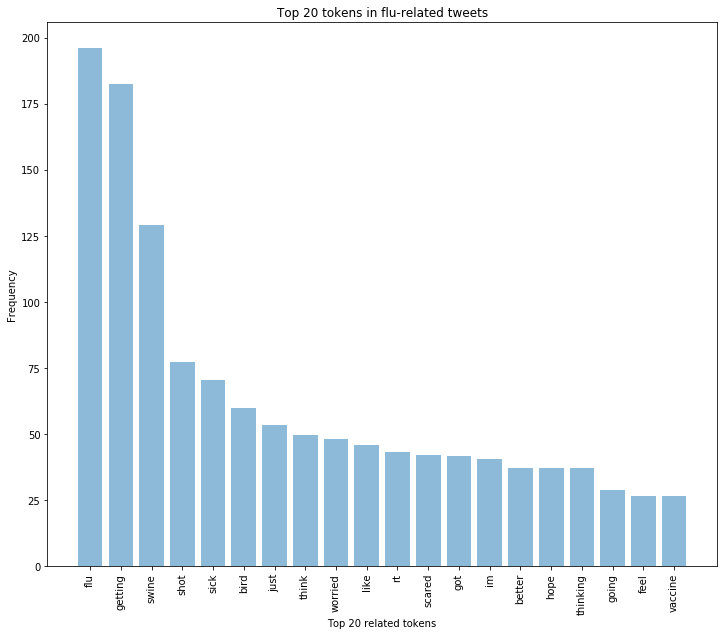

In [30]:
y = np.arange(20)
plt.figure(figsize=(12,10))
plt.bar(y, term_freq_df.sort_values(by='related', ascending=False)['related'][:20], align='center', alpha=0.5)
plt.xticks(y, term_freq_df.sort_values(by='related', ascending=False)['related'][:20].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 20 related tokens')
plt.title('Top 20 tokens in flu-related tweets')

### Top 10 Tokens in Unrelated Tweets

Text(0.5,1,'Top 20 tokens in unrelated tweets')

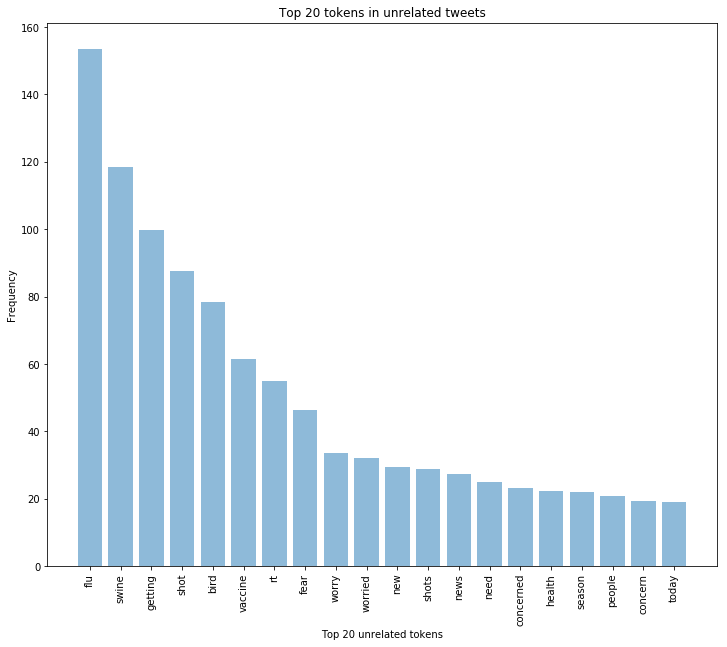

In [31]:
y = np.arange(20)
plt.figure(figsize=(12,10))
plt.bar(y, term_freq_df.sort_values(by='unrelated', ascending=False)['unrelated'][:20], align='center', alpha=0.5)
plt.xticks(y, term_freq_df.sort_values(by='unrelated', ascending=False)['unrelated'][:20].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 20 unrelated tokens')
plt.title('Top 20 tokens in unrelated tweets')

# Exploratory Data Analysis

## Descriptive Visualizations

No handles with labels found to put in legend.


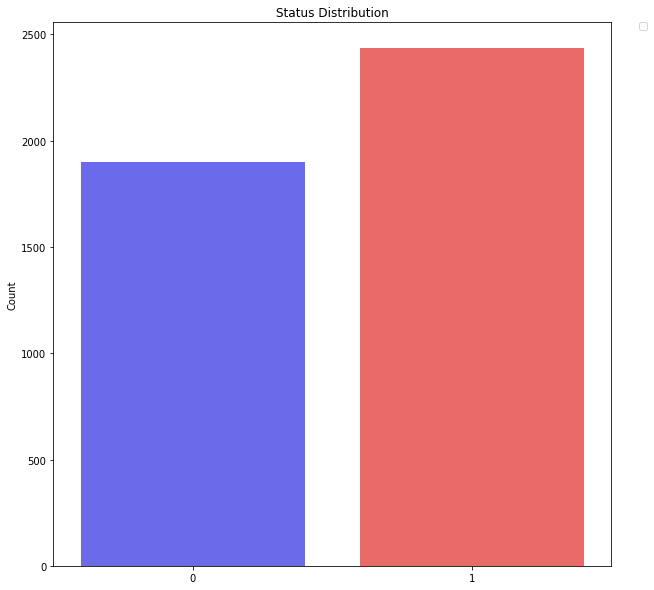

In [43]:
#distribution of annotated dataset (0/1)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.countplot(x="status", data=df, palette='seismic')
ax.set_title('Status Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Machine Learning Classification Algorithms

## Naive Bayes

In [20]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
preds = nb.predict(x_test)
y_score = nb.predict_proba(x_test)

### Metrics

Accuracy Score for model: 72.38%
Precision Score for model: 68.61%
Recall Score for model: 92.17%
F1 Score for model: 78.66%


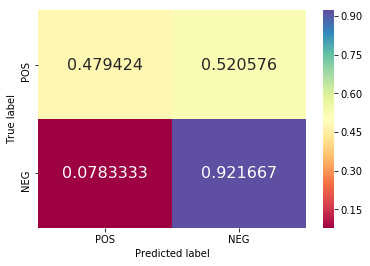

AUC: 0.8134156378600823


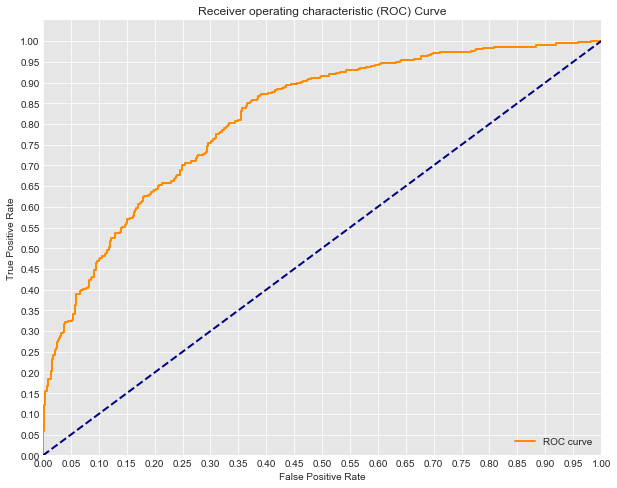

In [21]:
def print_metrics(model, x_test, y_test):
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print("Accuracy Score for model: {:.4}%".format(accuracy * 100))
    print("Precision Score for model: {:.4}%".format(precision * 100))
    print("Recall Score for model: {:.4}%".format(recall * 100))
    print("F1 Score for model: {:.4}%".format(f1 * 100))
    return accuracy, precision, recall, f1
    

def cm_plot(labels, predictions, normalize=False, cmap='Spectral'):
    cm = confusion_matrix(labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, ['POS', 'NEG'], ['POS', 'NEG'])
    sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap=cmap)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.colorbar()
    plt.show()

def plot_roc_curve(labels, predictions, y_score):
    fpr, tpr, thresholds = roc_curve(labels, y_score)
    print('AUC: {}'.format(auc(fpr, tpr)))
    #Seaborns Beautiful Styling
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

nb_accuracy, nb_precision, nb_recall, nb_f1 = print_metrics(nb,x_test,y_test)
cm_plot(y_test,preds, normalize=True, cmap='Spectral')
plot_roc_curve(y_test,preds, y_score[:,1])

## Logistic Regression

In [23]:
log = LogisticRegression()
log = log.fit(x_train, y_train)
preds = log.predict(x_test)
y_score = log.decision_function(x_test)

### Metrics

Accuracy Score for model: 74.86%
Precision Score for model: 73.87%
Recall Score for model: 84.33%
F1 Score for model: 78.75%


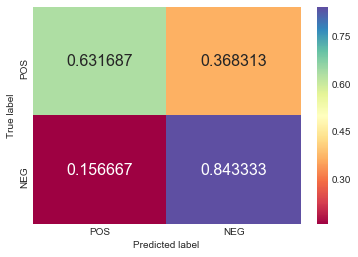

AUC: 0.8229492455418381


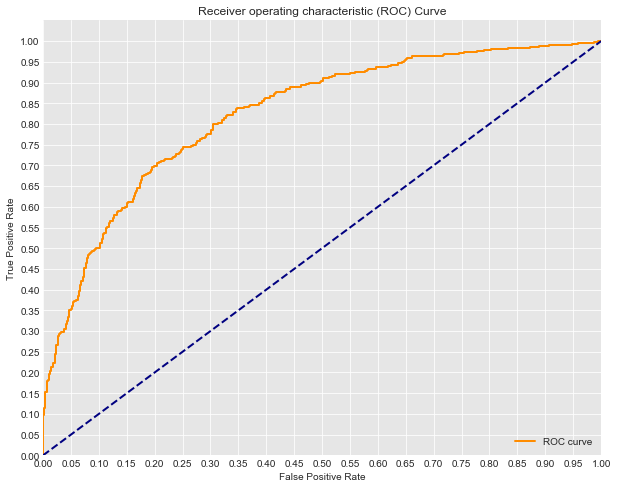

In [24]:
log_accuracy, log_precision, log_recall, log_f1 = print_metrics(log,x_test,y_test)
cm_plot(y_test,preds,normalize=True)
plot_roc_curve(y_test,preds,y_score)

### Hyperparameter Tuning

**L1 vs. L2 Regularization**

AUC for l1: 0.8117729766803842
AUC for l2: 0.822071330589849


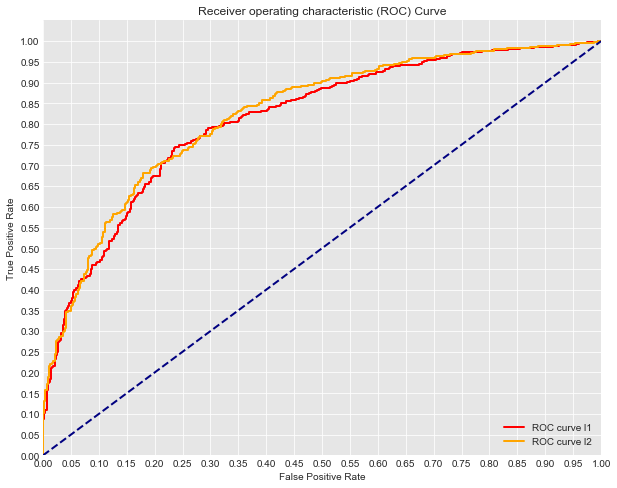

In [25]:
#compare L1 & L2 regularization
penalties = ['l1', 'l2']
colors = ['r', 'orange']

plt.figure(figsize=(10,8))

for n, pen in enumerate(penalties):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, penalty=pen) #Starter code
    model_log = logreg.fit(x_train, y_train)
    #Predict
    y_hat_test = logreg.predict(x_test)
    y_score = logreg.fit(x_train, y_train).decision_function(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('AUC for {}: {}'.format(str(pen), auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(pen))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Balanced Class Weights**

AUC for balanced: 0.8203737997256516
AUC for None: 0.822071330589849


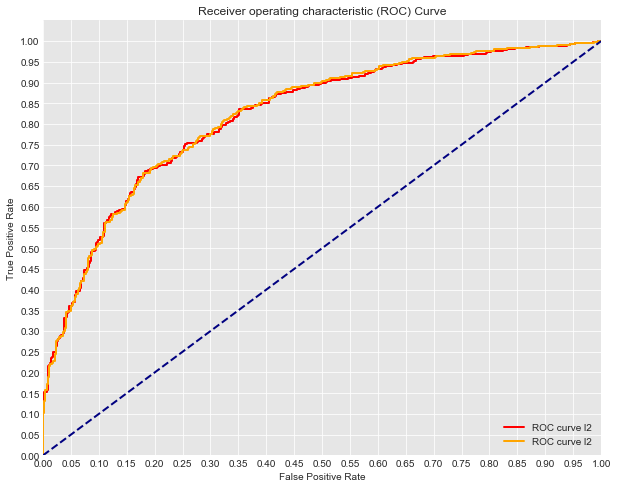

In [26]:
#compare L1 & L2 regularization
wgts = ['balanced', None]
colors = ['r', 'orange']

plt.figure(figsize=(10,8))

for n, wgt in enumerate(wgts):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, class_weight=wgt) #Starter code
    model_log = logreg.fit(x_train, y_train)
    #Predict
    y_hat_test = logreg.predict(x_test)
    y_score = logreg.fit(x_train, y_train).decision_function(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('AUC for {}: {}'.format(str(wgt), auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(pen))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [27]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(x_train, y_train)
preds = forest.predict(x_test)
y_score = forest.predict_proba(x_test)

### Metrics

Accuracy Score for model: 58.47%
Precision Score for model: 57.12%
Recall Score for model: 99.67%
F1 Score for model: 72.62%


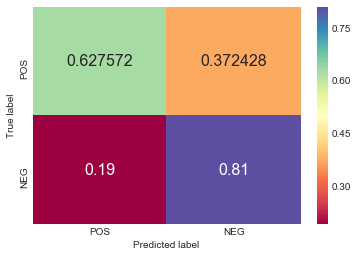

AUC: 0.8012088477366254


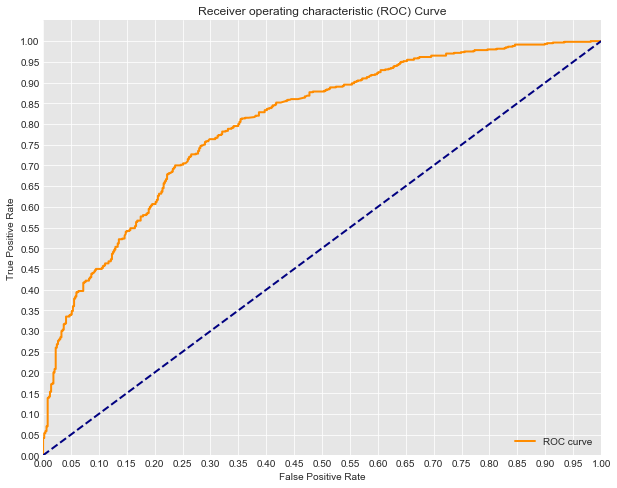

In [43]:
print_metrics(forest,x_test,y_test)
cm_plot(y_test,preds,normalize=True)
plot_roc_curve(y_test,preds,y_score[:,1])

### Hyperparameter Tuning

In [18]:
#adjust n_estimators

## Gradient Boosting

In [44]:
#adjust learning rate
gradboost = GradientBoostingClassifier(random_state = 123, max_depth = 5, learning_rate = 0.01)
gradboost.fit(x_train, y_train)
preds = gradboost.predict(x_test)
y_score = gradboost.predict_proba(x_test)

### Metrics

Accuracy Score for model: 66.02%
Precision Score for model: 64.35%
Recall Score for model: 86.33%
F1 Score for model: 73.74%


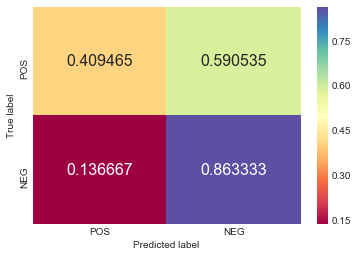

AUC: 0.7568775720164609


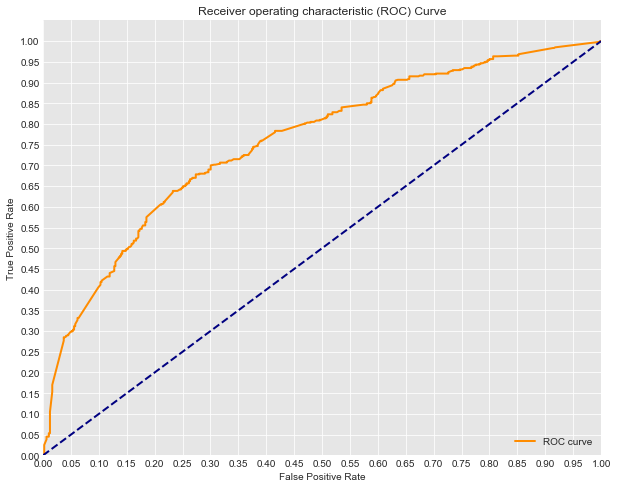

In [45]:
gb_accuracy, gb_precision, gb_recall, gb_f1 = print_metrics(gradboost,x_test,y_test)
cm_plot(y_test,preds,normalize=True)
plot_roc_curve(y_test,preds,y_score[:,1])

## AdaBoost

In [31]:
adaboost = AdaBoostClassifier(n_estimators=100)
adaboost.fit(x_train, y_train)
preds = adaboost.predict(x_test)
y_score = adaboost.predict_proba(x_test)

### Metrics

Accuracy Score for model: 72.74%
Precision Score for model: 72.29%
Recall Score for model: 82.17%
F1 Score for model: 76.91%


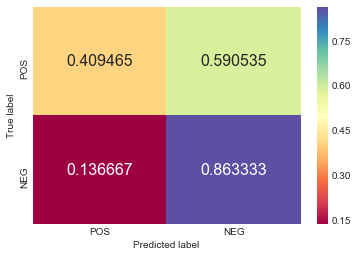

AUC: 0.7568775720164609


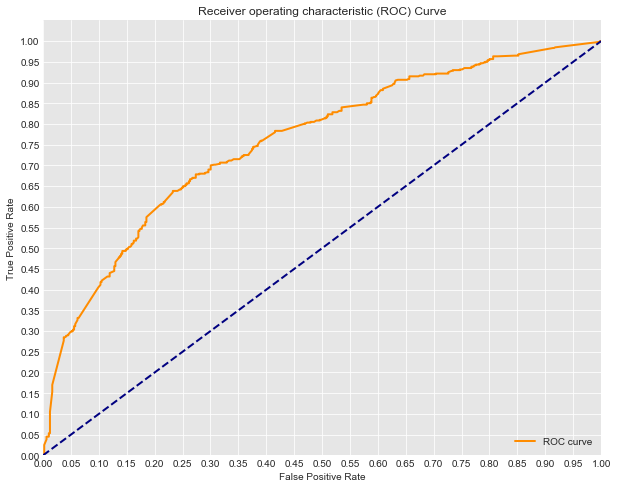

In [46]:
ada_accuracy, ada_precision, ada_recall, ada_f1 = print_metrics(adaboost,x_test,y_test)
cm_plot(y_test,preds,normalize=True)
plot_roc_curve(y_test,preds,y_score[:,1])

## Support Vector Machine

In [48]:
svm = SVC(kernel='linear', probability=True)
svm = svm.fit(x_train, y_train) 
preds = svm.predict(x_test)
y_score = svm.predict_proba(x_test)

In [34]:
#visualization
#https://github.com/learn-co-students/ds-support-vector-machines-lab-nyc-career-ds-062518/tree/solution

### Metrics

Accuracy Score for model: 72.84%
Precision Score for model: 72.86%
Recall Score for model: 81.0%
F1 Score for model: 76.72%


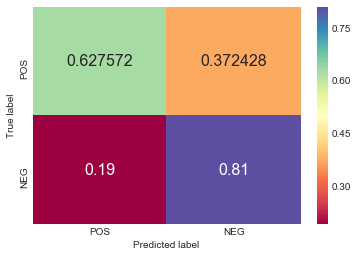

AUC: 0.809718792866941


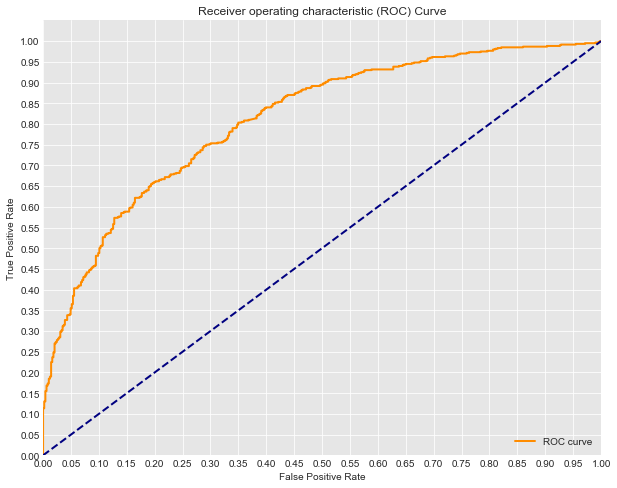

In [49]:
svm_accuracy, svm_precision, svm_recall, svm_f1 = print_metrics(svm,x_test,y_test)
cm_plot(y_test,preds,normalize=True)
plot_roc_curve(y_test,preds, y_score[:,1])

# Feed-Forward Neural Net: Multi-Layer Perceptron 

In [128]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import optimizers
from keras.models import model_from_json
from sklearn.externals import joblib
from keras import regularizers

### Hyperparameters

In [137]:
epochs=25
optimizer = optimizers.Adam(lr=0.00003, decay=0.0001)
# optimizer = optimizers.SGD(lr=0.003, decay=0.0001, momentum=0.9)
batch_size=32
loss='binary_crossentropy'
activation='relu'
out_activation='sigmoid'

In [138]:
tbcallback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=batch_size, 
                                         write_graph=True, write_images=True)

### Model - Adam

In [139]:
model = Sequential()
model.add(Dense(150, input_dim=len(tfidvec.get_feature_names()), kernel_regularizer=regularizers.l1(0.005), activation=activation))
model.add(Dropout(0.3))
model.add(Dense(75, kernel_regularizer=regularizers.l1(0.005), activation=activation))
model.add(Dropout(0.3))
model.add(Dense(1, activation=out_activation))
model.load_weights("mlp_adam_3_50.h5")
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 150)               1111950   
_________________________________________________________________
dropout_16 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 75)                11325     
_________________________________________________________________
dropout_17 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 76        
Total params: 1,123,351
Trainable params: 1,123,351
Non-trainable params: 0
_________________________________________________________________


In [140]:
#clear logs first
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    verbose=1, validation_data=[x_test, y_test], callbacks=[tbcallback])

Train on 3422 samples, validate on 1141 samples
Epoch 1/25
3422/3422 [==============================] - 21s 6ms/step - loss: 85.8280 - acc: 0.9752 - val_loss: 78.0280 - val_acc: 0.7318
Epoch 2/25
3422/3422 [==============================] - 20s 6ms/step - loss: 70.0496 - acc: 0.9725 - val_loss: 63.2968 - val_acc: 0.7327
Epoch 3/25
3422/3422 [==============================] - 21s 6ms/step - loss: 56.4218 - acc: 0.9702 - val_loss: 50.6723 - val_acc: 0.7309
Epoch 4/25
3422/3422 [==============================] - 23s 7ms/step - loss: 44.8490 - acc: 0.9684 - val_loss: 40.0568 - val_acc: 0.7344
Epoch 5/25
3422/3422 [==============================] - 23s 7ms/step - loss: 35.2448 - acc: 0.9652 - val_loss: 31.3523 - val_acc: 0.7379
Epoch 6/25
3422/3422 [==============================] - 20s 6ms/step - loss: 27.4645 - acc: 0.9544 - val_loss: 24.3599 - val_acc: 0.7379
Epoch 7/25
3422/3422 [==============================] - 23s 7ms/step - loss: 21.2540 - acc: 0.9307 - val_loss: 18.7789 - val_acc: 

### Metrics

1141/1141 [==============================] - 2s 2ms/step
[0.7295383785566623, 0.9789596727060199]
[1.1051025944357897, 0.7221735324073946]


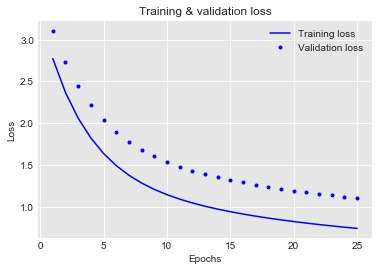

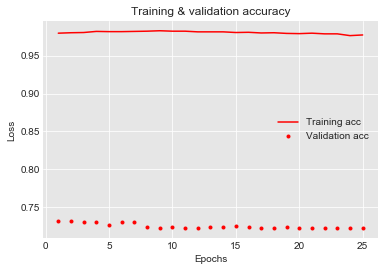

In [134]:
results_train = model.evaluate(x_train, y_train)
results_test = model.evaluate(x_test, y_test)
mlp_accuracy = results_test[1]
print(results_train)
print(results_test)
val_dict = history.history

loss_values = val_dict['loss']
val_loss_values = val_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'b.', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc_values = val_dict['acc'] 
val_acc_values = val_dict['val_acc']
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'r.', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [123]:
# serialize model to JSON
model_json = model.to_json()
with open("mlp_adam_3_50.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("mlp_adam_3_50.h5")
print("Saved model to disk")

Saved model to disk


### Model - SGD

In [ ]:
model = Sequential()
model.add(Dense(150, input_dim=len(tfidvec.get_feature_names()), activation=activation))
model.add(Dropout(0.3))
# model.add(Dense(150, activation=activation))
# model.add(Dropout(0.3))
model.add(Dense(1, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
model.summary()

In [ ]:
#clear logs first
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    verbose=1, validation_data=[x_test, y_test], callbacks=[tbcallback])

### Metrics

In [ ]:
results_train = model.evaluate(x_train, y_train)
results_test = model.evaluate(x_test, y_test)
mlp_accuracy = results_test[1]
print(results_train)
print(results_test)

plot_loss('mlp_sgd_loss.pkl')
plot_accuracy('mlp_sgd_loss.pkl')

# Vectorizer & Classifier Performance Comparison

In [82]:
def classifiers(x_train, y_train):
    nb = MultinomialNB()
    nb.fit(x_train, y_train)
    log = LogisticRegression()
    log.fit(x_train, y_train)
    forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
    forest.fit(x_train, y_train)
    gradboost = GradientBoostingClassifier(random_state = 123, max_depth = 5, learning_rate = 0.01)
    gradboost.fit(x_train, y_train)
    adaboost = AdaBoostClassifier(n_estimators=100)
    adaboost.fit(x_train, y_train)
    svm = SVC(kernel='linear', probability=True)
    svm.fit(x_train, y_train)
    return [nb, log, forest, gradboost, adaboost, svm]

def classifier_performance(vectorizer, train_data, test_data, y_test):
    accuracy_df = []
    x_train = vectorizer.fit_transform(train_data)
    x_test = vectorizer.transform(test_data)
    #instantiate classifier objects
    classifier_list = classifiers(x_train, y_train)
    #display accuracy dataframe
    for classifier in classifier_list:
        preds = classifier.predict(x_test)
        accuracy = accuracy_score(y_test, preds)
        accuracy_df.append(accuracy*100)
    accuracy_df = pd.DataFrame(accuracy_df)
    classifiers_key = ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'Gradient Boost', 'Adaboost',
                      'Support Vector Machine']
    accuracy_df['Model']=classifiers_key
    accuracy_df.rename(columns={0: 'Accuracy'}, inplace=True)
    fin_accuracy_df = accuracy_df[['Model', 'Accuracy']]
    return fin_accuracy_df


In [86]:
data = df['text']
labels = df['status']
train_data, test_data, y_train, y_test = train_test_split(data, labels)
tfidfvec = TfidfVectorizer(stop_words='english', tokenizer=tokenize)
tfidfvec2 = TfidfVectorizer(stop_words='english', tokenizer=tokenize, ngram_range=(1,2))
tfidfvec3 = TfidfVectorizer(stop_words='english', tokenizer=tokenize, ngram_range=(1,3))
countvec = CountVectorizer(stop_words='english', tokenizer=tokenize)
countvec2 = CountVectorizer(stop_words='english', tokenizer=tokenize, ngram_range=(1,2))
countvec3 = CountVectorizer(stop_words='english', tokenizer=tokenize, ngram_range=(1,3))

### Count Vectorizer

**Unigram**

In [83]:
classifier_performance(countvec, train_data, test_data, y_test)

,Model,Accuracy
0,Naive Bayes,71.981567
1,Logistic Regression,69.953917
2,Random Forest,59.631336
3,Gradient Boost,64.516129
4,Adaboost,69.400922
5,Support Vector Machine,69.216590


**Bigram**

In [87]:
classifier_performance(countvec2, train_data, test_data, y_test)

,Model,Accuracy
0,Naive Bayes,73.456221
1,Logistic Regression,72.811060
2,Random Forest,59.539171
3,Gradient Boost,65.253456
4,Adaboost,69.493088
5,Support Vector Machine,70.230415


**Trigram**

In [88]:
classifier_performance(countvec3, train_data, test_data, y_test)

,Model,Accuracy
0,Naive Bayes,72.718894
1,Logistic Regression,72.626728
2,Random Forest,59.539171
3,Gradient Boost,65.529954
4,Adaboost,69.677419
5,Support Vector Machine,70.322581


### TF-IDF Vectorizer

**Unigram**

In [84]:
classifier_performance(tfidfvec, train_data, test_data, y_test)

,Model,Accuracy
0,Naive Bayes,72.258065
1,Logistic Regression,71.244240
2,Random Forest,60.552995
3,Gradient Boost,63.225806
4,Adaboost,69.493088
5,Support Vector Machine,70.599078


**Bigram**

In [89]:
classifier_performance(tfidfvec2, train_data, test_data, y_test)

,Model,Accuracy
0,Naive Bayes,73.179724
1,Logistic Regression,71.981567
2,Random Forest,58.801843
3,Gradient Boost,63.870968
4,Adaboost,68.847926
5,Support Vector Machine,71.797235


**Trigram**

In [90]:
classifier_performance(tfidfvec3, train_data, test_data, y_test)

,Model,Accuracy
0,Naive Bayes,72.995392
1,Logistic Regression,72.350230
2,Random Forest,59.447005
3,Gradient Boost,64.239631
4,Adaboost,67.649770
5,Support Vector Machine,72.165899


**SELECT TF-IDF WITH BI-GRAMS**

In [ ]:
metrics_df = classifier_performance(tfidfvec2, train_data, test_data, y_test)
#add shallow learning metrics too 
metrics_df.to_csv('metrics_df.csv')

## ROC Curves

In [ ]:
#roc curve with all classifiers 
# https://stats.stackexchange.com/questions/212720/roc-curves-for-different-classifiers

# Next Steps/Notes:
* Add more annotated tweets 
* Doc2Vec

In [120]:
def plot_most_predictive_features():
    x_train = tfidfvec2.fit_transform(train_data)
    x_test = tfidfvec2.transform(test_data)
    chi2score = chi2(x_train, y_train)[0]

    plt.figure(figsize=(15,10))
    wscores = list(zip(tfidfvec2.get_feature_names(), chi2score))
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = list(zip(*wchi2[-20:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]
    plt.barh(x,topchi2[1], align='center', alpha=0.2)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels)
    plt.xlabel('$\chi^2$')
    plt.title('Most predictive features and associated Chi-square scores')

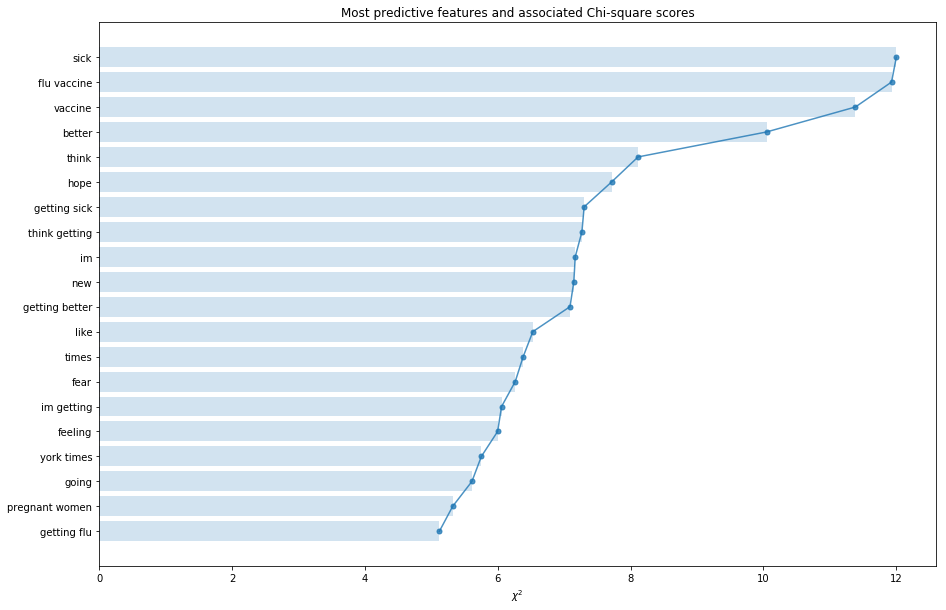

In [121]:
plot_most_predictive_features()

# Storing models in .pickle files

In [ ]:
joblib.dump(nb, 'nb.pkl')
joblib.dump(logreg, 'log.pkl') 
joblib.dump(forest, 'forest.pkl')
joblib.dump(gradboost, 'gradboost.pkl') 
joblib.dump(adaboost, 'adaboost.pkl') 
joblib.dump(svm, 'svm.pkl') 